# 3. Implementing a Neural Network

In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

First let us setup some code for this notebook:

In [1]:
import os
import cPickle as pickle
from math import sqrt, ceil

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The neural network parameters will be stored in a dictionary (`model` below), where the keys are the parameter names and the values are numpy arrays. Below, we initialize toy data and a toy model that we will use to verify your implementations.

In [2]:
input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
  model = {}
  model['W1'] = np.linspace(-0.2, 0.6, num=input_size*hidden_size).reshape(input_size, hidden_size)
  model['b1'] = np.linspace(-0.3, 0.7, num=hidden_size)
  model['W2'] = np.linspace(-0.4, 0.1, num=hidden_size*num_classes).reshape(hidden_size, num_classes)
  model['b2'] = np.linspace(-0.5, 0.9, num=num_classes)
  return model

def init_toy_data():
  X = np.linspace(-0.2, 0.5, num=num_inputs*input_size).reshape(num_inputs, input_size)
  y = np.array([0, 1, 2, 2, 1])
  return X, y

model = init_toy_model()
X, y = init_toy_data()

The first function we need, `two_layer_net()`, is very similar to the loss functions you have written for the previous SVM and Softmax exercises: It takes the data and weights and computes the class **scores**, the **loss**, and the **gradients** on the parameters.  

## Forward pass: compute scores

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs:

In [3]:
def two_layer_net(X, model, y=None, reg=0.0):
  """
  Compute the loss and gradients for a two layer fully connected neural network.
  The net has an input dimension of D, a hidden layer dimension of H, and
  performs classification over C classes. We use a softmax loss function and L2
  regularization the the weight matrices. The two layer net should use a ReLU
  nonlinearity after the first affine layer.

  The two layer net has the following architecture:

  input - fully connected layer - ReLU - fully connected layer - softmax

  The outputs of the second fully-connected layer are the scores for each
  class.

  Inputs:
  - X: Input data of shape (N, D). Each X[i] is a training sample.
  - model: Dictionary mapping parameter names to arrays of parameter values.
    It should contain the following:
    - W1: First layer weights; has shape (D, H)
    - b1: First layer biases; has shape (H,)
    - W2: Second layer weights; has shape (H, C)
    - b2: Second layer biases; has shape (C,)
  - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
    an integer in the range 0 <= y[i] < C. This parameter is optional; if it
    is not passed then we only return scores, and if it is passed then we
    instead return the loss and gradients.
  - reg: Regularization strength.

  Returns:
  If y not is passed, return a matrix scores of shape (N, C) where scores[i, c]
  is the score for class c on input X[i].

  If y is not passed, instead return a tuple of:
  - loss: Loss (data loss and regularization loss) for this batch of training
    samples.
  - grads: Dictionary mapping parameter names to gradients of those parameters
    with respect to the loss function. This should have the same keys as model.
  """

  # unpack variables from the model dictionary
  W1,b1,W2,b2 = model['W1'], model['b1'], model['W2'], model['b2']
  N, D = X.shape

  # compute the forward pass
  scores = None
  #############################################################################
  # TODO: Perform the forward pass, computing the class scores for the input. #
  # Store the result in the scores variable, which should be an array of      #
  # shape (N, C).                                                             #
  #############################################################################
  hidden_layer = np.maximum(0, np.dot(X, W1) + b1) # note, ReLU activation
  scores = np.dot(hidden_layer, W2) + b2
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
  
  # If the targets are not given then jump out, we're done
  if y is None:
    return scores

  # compute the loss
  loss = None
  #############################################################################
  # TODO: Finish the forward pass, and compute the loss. This should include  #
  # both the data loss and L2 regularization for W1 and W2. Store the result  #
  # in the variable loss, which should be a scalar. Use the Softmax           #
  # classifier loss. So that your results match ours, multiply the            #
  # regularization loss by 0.5                                                #
  #############################################################################
  probs = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True) # [N x K]  
  # compute the loss: average cross-entropy loss and regularization
  correct_logprobs = -np.log(probs[range(N),y])
  data_loss = np.sum(correct_logprobs)/N
  reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)
  loss = data_loss + reg_loss
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################

  # compute the gradients
  grads = {}
  #############################################################################
  # TODO: Compute the backward pass, computing the derivatives of the weights #
  # and biases. Store the results in the grads dictionary. For example,       #
  # grads['W1'] should store the gradient on W1, and be a matrix of same size #
  #############################################################################
  # first backprop into parameters W2 and b2
  dscores = probs
  dscores[range(N),y] -= 1
  dscores /= N
  grads['W2'] = np.dot(hidden_layer.T, dscores) + reg * W2
  grads['b2'] = np.sum(dscores, axis=0, keepdims=False)
  # next backprop into hidden layer
  dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
  dhidden[hidden_layer <= 0] = 0
  # finally into W,b
  grads['W1'] = np.dot(X.T, dhidden) + reg * W1
  grads['b1'] = np.sum(dhidden, axis=0, keepdims=False)

  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################

  return loss, grads

We can now test this on our toy model, and the `scores` should be very small compared to the `correct_scores`:

In [4]:
scores = two_layer_net(X, model)
print scores
correct_scores = [[-0.5328368, 0.20031504, 0.93346689],
 [-0.59412164, 0.15498488, 0.9040914 ],
 [-0.67658362, 0.08978957, 0.85616275],
 [-0.77092643, 0.01339997, 0.79772637],
 [-0.89110401, -0.08754544, 0.71601312]]

print 'Difference between your scores and correct scores:'
print np.sum(np.abs(scores - correct_scores))

[[-0.5328368   0.20031504  0.93346689]
 [-0.59412164  0.15498488  0.9040914 ]
 [-0.67658362  0.08978957  0.85616275]
 [-0.77092643  0.01339997  0.79772637]
 [-0.89110401 -0.08754544  0.71601312]]
Difference between your scores and correct scores:
3.84868230029e-08


## Forward pass: compute loss
Now go back to `two_layer_net()` above and implement the second part that computes the data and regularizaion loss. Once again the `loss`  it returns should be close to the `correct_loss` which we check below:

In [5]:
reg = 0.1
loss, _ = two_layer_net(X, model, y, reg)
correct_loss = 1.38191946092

print 'Difference between your loss and correct loss:'
print np.sum(np.abs(loss - correct_loss))

Difference between your loss and correct loss:
4.67692551354e-12


## Backward pass: compute gradients

Ok now go back and implement the final part: the gradients of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. 

Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient checker:

In [6]:
def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
  """ 
  a naive implementation of numerical gradient of f at x 
  - f should be a function that takes a single argument
  - x is the point (numpy array) to evaluate the gradient at
  """ 

  fx = f(x) # evaluate function value at original point
  grad = np.zeros_like(x)

  # iterate over all indexes in x
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:
    # evaluate function at x+h
    ix = it.multi_index
    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evalute f(x + h)
    x[ix] = oldval - h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # restore

    # compute the partial derivative with centered formula
    grad[ix] = (fxph - fxmh) / (2 * h) # the slope
    if verbose:
      print ix, grad[ix]
    it.iternext() # step to next dimension

  return grad

In [7]:
loss, grads = two_layer_net(X, model, y, reg)

for param_name in grads:
  param_grad_num = eval_numerical_gradient(lambda W: two_layer_net(X, model, y, reg)[0], model[param_name], verbose=False)
  print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

W1 max relative error: 4.426512e-09
W2 max relative error: 1.786138e-09
b2 max relative error: 8.190173e-11
b1 max relative error: 5.435436e-08


<hr>

## Train the network
To train the network we will use SGD with Momentum. In the last exercise you implemented vanilla SGD. You will now implement the momentum update and the RMSProp update. 

Let us define a  `ClassifierTrainer`  class which performs optimization given an arbitrary cost function data, and model. By default it uses vanilla GD, which we have already implemented for you:

In [8]:
class ClassifierTrainer(object):
  """ The trainer class performs SGD with momentum on a cost function """
  def __init__(self):
    self.step_cache = {} # for storing velocities in momentum update

  def train(self, X, y, X_val, y_val, 
            model, loss_function, 
            reg=0.0,
            learning_rate=1e-2, momentum=0, learning_rate_decay=0.95,
            update='momentum', sample_batches=True,
            num_epochs=30, batch_size=100, acc_frequency=None,
            verbose=False):
    """
    Optimize the parameters of a model to minimize a loss function. We use
    training data X and y to compute the loss and gradients, and periodically
    check the accuracy on the validation set.

    Inputs:
    - X: Array of training data; each X[i] is a training sample.
    - y: Vector of training labels; y[i] gives the label for X[i].
    - X_val: Array of validation data
    - y_val: Vector of validation labels
    - model: Dictionary that maps parameter names to parameter values. Each
      parameter value is a numpy array.
    - loss_function: A function that can be called in the following ways:
      scores = loss_function(X, model, reg=reg)
      loss, grads = loss_function(X, model, y, reg=reg)
    - reg: Regularization strength. This will be passed to the loss function.
    - learning_rate: Initial learning rate to use.
    - momentum: Parameter to use for momentum updates.
    - learning_rate_decay: The learning rate is multiplied by this after each
      epoch.
    - update: The update rule to use. One of 'sgd', 'momentum', or 'rmsprop'.
    - sample_batches: If True, use a minibatch of data for each parameter update
      (stochastic gradient descent); if False, use the entire training set for
      each parameter update (gradient descent).
    - num_epochs: The number of epochs to take over the training data.
    - batch_size: The number of training samples to use at each iteration.
    - acc_frequency: If set to an integer, we compute the training and
      validation set error after every acc_frequency iterations.
    - verbose: If True, print status after each epoch.

    Returns a tuple of:
    - best_model: The model that got the highest validation accuracy during
      training.
    - loss_history: List containing the value of the loss function at each
      iteration.
    - train_acc_history: List storing the training set accuracy at each epoch.
    - val_acc_history: List storing the validation set accuracy at each epoch.
    """

    N = X.shape[0]

    if sample_batches:
      iterations_per_epoch = N / batch_size # using SGD
    else:
      iterations_per_epoch = 1 # using GD
    num_iters = num_epochs * iterations_per_epoch
    epoch = 0
    best_val_acc = 0.0
    best_model = {}
    loss_history = []
    train_acc_history = []
    val_acc_history = []
    for it in xrange(num_iters):
      if it % 10 == 0:  print 'starting iteration ', it

      # get batch of data
      if sample_batches:
        batch_mask = np.random.choice(N, batch_size)
        X_batch = X[batch_mask]
        y_batch = y[batch_mask]
      else:
        # no SGD used, full gradient descent
        X_batch = X
        y_batch = y

      # evaluate cost and gradient
      cost, grads = loss_function(X_batch, model, y_batch, reg)
      loss_history.append(cost)

      # perform a parameter update
      for p in model:
        # compute the parameter step
        if update == 'sgd':
          dx = -learning_rate * grads[p]
        elif update == 'momentum':
          if not p in self.step_cache: 
            self.step_cache[p] = np.zeros(grads[p].shape)
          dx = np.zeros_like(grads[p]) # you can remove this after
          #####################################################################
          # TODO: implement the momentum update formula and store the step    #
          # update into variable dx. You should use the variable              #
          # step_cache[p] and the momentum strength is stored in momentum.    #
          # Don't forget to also update the step_cache[p].                    #
          #####################################################################
          dx = momentum * self.step_cache[p] - learning_rate*grads[p]
          self.step_cache[p] = dx
          #####################################################################
          #                      END OF YOUR CODE                             #
          #####################################################################
        elif update == 'rmsprop':
          decay_rate = 0.99 # you could also make this an option
          if not p in self.step_cache: 
            self.step_cache[p] = np.zeros(grads[p].shape)
          dx = np.zeros_like(grads[p]) # you can remove this after
          #####################################################################
          # TODO: implement the RMSProp update and store the parameter update #
          # dx. Don't forget to also update step_cache[p]. Use smoothing 1e-8 #
          #####################################################################
          self.step_cache[p] = decay_rate * self.step_cache[p] + (1 - decay_rate) * grads[p] * grads[p]
          dx -= learning_rate * grads[p]/( np.sqrt(self.step_cache[p] + 1e-8))
          #####################################################################
          #                      END OF YOUR CODE                             #
          #####################################################################
        else:
          raise ValueError('Unrecognized update type "%s"' % update)

        # update the parameters
        model[p] += dx

      # every epoch perform an evaluation on the validation set
      first_it = (it == 0)
      epoch_end = (it + 1) % iterations_per_epoch == 0
      acc_check = (acc_frequency is not None and it % acc_frequency == 0)
      if first_it or epoch_end or acc_check:
        if it > 0 and epoch_end:
          # decay the learning rate
          learning_rate *= learning_rate_decay
          epoch += 1

        # evaluate train accuracy
        if N > 1000:
          train_mask = np.random.choice(N, 1000)
          X_train_subset = X[train_mask]
          y_train_subset = y[train_mask]
        else:
          X_train_subset = X
          y_train_subset = y
        scores_train = loss_function(X_train_subset, model)
        y_pred_train = np.argmax(scores_train, axis=1)
        train_acc = np.mean(y_pred_train == y_train_subset)
        train_acc_history.append(train_acc)

        # evaluate val accuracy
        scores_val = loss_function(X_val, model)
        y_pred_val = np.argmax(scores_val, axis=1)
        val_acc = np.mean(y_pred_val ==  y_val)
        val_acc_history.append(val_acc)
        
        # keep track of the best model based on validation accuracy
        if val_acc > best_val_acc:
          # make a copy of the model
          best_val_acc = val_acc
          best_model = {}
          for p in model:
            best_model[p] = model[p].copy()

        # print progress if needed
        if verbose:
          print ('Finished epoch %d / %d: cost %f, train: %f, val %f, lr %e'
                 % (epoch, num_epochs, cost, train_acc, val_acc, learning_rate))

    if verbose:
      print 'finished optimization. best validation accuracy: %f' % (best_val_acc, )
    # return the best model and the training history statistics
    return best_model, loss_history, train_acc_history, val_acc_history

First, lets run the optimization using Vanilla Gradient Descent. Notice we are using the `sample_batches=False` so we are performing Gradient Descent:

In [9]:
model = init_toy_model()
trainer = ClassifierTrainer()

best_model, loss_history, _, _ = trainer.train(X, y, X, y,
                                             model, two_layer_net,
                                             reg=0.001,
                                             learning_rate=1e-1, momentum=0.0, learning_rate_decay=1,
                                             update='sgd', sample_batches=False,
                                             num_epochs=100,
                                             verbose=False)
print 'Final loss with vanilla SGD: %f' % (loss_history[-1], )

starting iteration  0
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
Final loss with vanilla SGD: 0.940686


### Momentum update


Now fill in the momentum update in the first missing code block inside the train function, and run the same optimization as above but with the momentum update. You should see a much better result in the final obtained loss:

In [10]:
model = init_toy_model()
trainer = ClassifierTrainer()

best_model, loss_history, _, _ = trainer.train(X, y, X, y,
                                             model, two_layer_net,
                                             reg=0.001,
                                             learning_rate=1e-1, momentum=0.9, learning_rate_decay=1,
                                             update='momentum', sample_batches=False,
                                             num_epochs=100,
                                             verbose=False)
correct_loss = 0.494394
print 'Final loss with momentum SGD: %f. We get: %f' % (loss_history[-1], correct_loss)

starting iteration  0
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
Final loss with momentum SGD: 0.494394. We get: 0.494394


### RMSProp

Now also implement the RMSProp update rule inside the `train` function and rerun the optimization:

In [11]:
model = init_toy_model()
trainer = ClassifierTrainer()

best_model, loss_history, _, _ = trainer.train(X, y, X, y,
                                             model, two_layer_net,
                                             reg=0.001,
                                             learning_rate=1e-1, momentum=0.9, learning_rate_decay=1,
                                             update='rmsprop', sample_batches=False,
                                             num_epochs=100,
                                             verbose=False)
correct_loss = 0.439368
print 'Final loss with RMSProp: %f. We get: %f' % (loss_history[-1], correct_loss)

starting iteration  0
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
Final loss with RMSProp: 0.439368. We get: 0.439368


<hr>

## Load the data
Now that you have implemented a two-layer network that passes gradient checks, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier!

In [12]:
#!wget -P /tmp/cifar-10 -c http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
#!tar xvzf /tmp/cifar-10/cifar-10-python.tar.gz  -C /tmp/cifar-10
#!rm /tmp/cifar-10/cifar-10-python.tar.gz

In [13]:
def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '/home/min-joon/cifar-10/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test

Now let us invoke the above function to get our data:

In [14]:
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


## Train a network

To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

First we initialize a two layer model:

In [15]:
def init_two_layer_model(input_size, hidden_size, output_size):
  """
  Initialize the weights and biases for a two-layer fully connected neural
  network. The net has an input dimension of D, a hidden layer dimension of H,
  and performs classification over C classes. Weights are initialized to small
  random values and biases are initialized to zero.

  Inputs:
  - input_size: The dimension D of the input data
  - hidden_size: The number of neurons H in the hidden layer
  - ouput_size: The number of classes C

  Returns:
  A dictionary mapping parameter names to arrays of parameter values. It has
  the following keys:
  - W1: First layer weights; has shape (D, H)
  - b1: First layer biases; has shape (H,)
  - W2: Second layer weights; has shape (H, C)
  - b2: Second layer biases; has shape (C,)
  """
  # initialize a model
  model = {}
  model['W1'] = 0.00001 * np.random.randn(input_size, hidden_size)
  model['b1'] = np.zeros(hidden_size)
  model['W2'] = 0.00001 * np.random.randn(hidden_size, output_size)
  model['b2'] = np.zeros(output_size)
  return model

In [16]:
model = init_two_layer_model(32*32*3, 50, 10) # input size, hidden size, number of classes
trainer = ClassifierTrainer()
best_model, loss_history, train_acc, val_acc = trainer.train(X_train, y_train, X_val, y_val,
                                             model, two_layer_net,
                                             num_epochs=5, reg=1.0,
                                             momentum=0.9, learning_rate_decay = 0.95,
                                             learning_rate=1e-5, verbose=True)

starting iteration  0
Finished epoch 0 / 5: cost 2.302593, train: 0.101000, val 0.098000, lr 1.000000e-05
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
starting iteration  110
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
starting iteration  160
starting iteration  170
starting iteration  180
starting iteration  190
starting iteration  200
starting iteration  210
starting iteration  220
starting iteration  230
starting iteration  240
starting iteration  250
starting iteration  260
starting iteration  270
starting iteration  280
starting iteration  290
starting iteration  300
starting iteration  310
starting iteration  320
starting iteration  330
starting iteration  340
starting iteration  350
starting iteration  360
starting iteration  370
starting iterat

## Debug the training

With the default parameters we provided above, you should get a validation accuracy of about 0.37 on the validation set. This isn't very good.

One strategy for getting insight into what is going wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

Let us plot the loss function and train / validation accuracies:

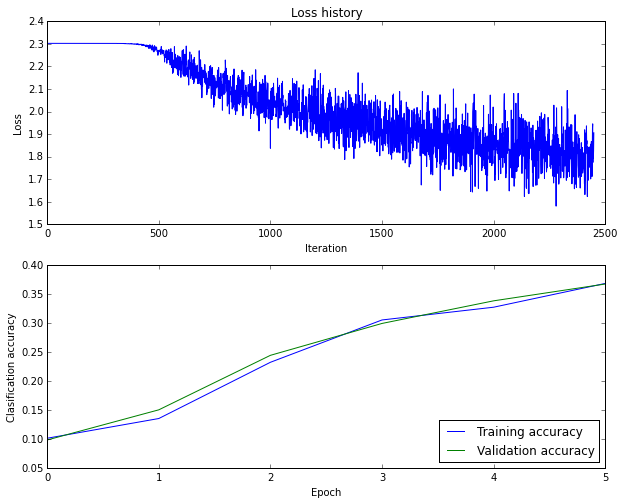

In [17]:
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')

To visualize the weights of the network we use the following helper:

In [18]:
def visualize_grid(Xs, ubound=255.0, padding=1):
  """
  Reshape a 4D tensor of image data to a grid for easy visualization.

  Inputs:
  - Xs: Data of shape (N, H, W, C)
  - ubound: Output grid will have values scaled to the range [0, ubound]
  - padding: The number of blank pixels between elements of the grid
  """
  (N, H, W, C) = Xs.shape
  grid_size = int(ceil(sqrt(N)))
  grid_height = H * grid_size + padding * (grid_size - 1)
  grid_width = W * grid_size + padding * (grid_size - 1)
  grid = np.zeros((grid_height, grid_width, C))
  next_idx = 0
  y0, y1 = 0, H
  for y in xrange(grid_size):
    x0, x1 = 0, W
    for x in xrange(grid_size):
      if next_idx < N:
        img = Xs[next_idx]
        low, high = np.min(img), np.max(img)
        grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
        # grid[y0:y1, x0:x1] = Xs[next_idx]
        next_idx += 1
      x0 += W + padding
      x1 += W + padding
    y0 += H + padding
    y1 += H + padding
  # grid_max = np.max(grid)
  # grid_min = np.min(grid)
  # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
  return grid

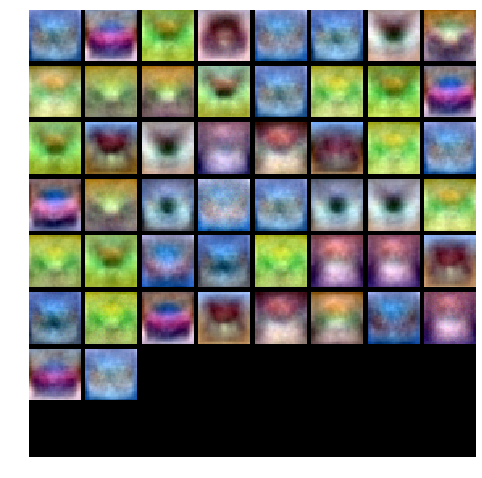

In [19]:
def show_net_weights(model):
    plt.imshow(visualize_grid(model['W1'].T.reshape(-1, 32, 32, 3), padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(model)

## Tune your hyperparameters

###What's wrong?
Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

###Tuning
Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the momentum and learning rate decay parameters, but you should be able to get good performance using the default values.

###Approximate results
You should be aim to achieve a classification accuracy of greater than 50% on the validation set. Our best network gets over 56% on the validation set.

###Experiment
You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [ ]:
best_model = None # store the best model into this 

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_model.                                                          #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous assignment.                         #
#################################################################################


from sklearn.grid_search import RandomizedSearchCV



param_grid = {'learning_rate' : 10 ** np.random.uniform(-4, -5),
             'reg' : np.random.uniform(0.5, 0,9),
             'momentum' : np.random.uniform(0.9, 0.95)}




#Randomized grid search


                

#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

In [ ]:
model = init_two_layer_model(32*32*3, 50, 10) # input size, hidden size, number of classes
trainer = ClassifierTrainer()

best_model, loss_history, train_acc, val_acc = trainer.train(X_train, y_train, X_val, y_val,
                                             model, two_layer_net,
                                             num_epochs=20, reg=0.6,
                                             momentum=0.94, learning_rate_decay = 0.9,
                                             learning_rate=4.5e-5,batch_size = 250,  verbose=False)



#num_epochs=80, reg=0.641,momentum=0.935963, learning_rate_decay = 0.973477,
#                                            learning_rate=4.4e-5,batch_size = 500,  verbose=True)
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')

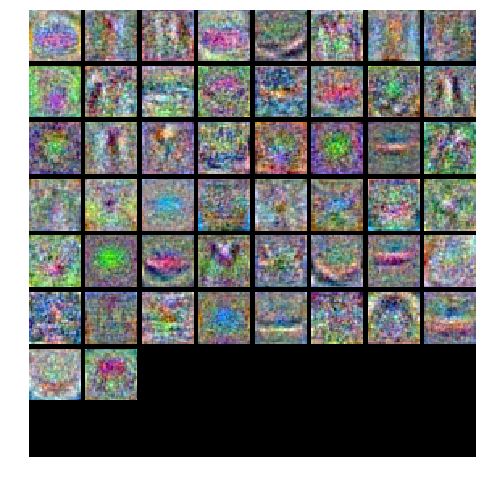

In [41]:
# visualize the weights
show_net_weights(best_model)

##Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set!

In [42]:
scores_test = two_layer_net(X_test, best_model)
print 'Test accuracy: ', np.mean(np.argmax(scores_test, axis=1) == y_test)

Test accuracy:  0.542
